In [44]:
import rasterio
from rasterio.plot import show
from rasterio.mask import mask
from rasterstats import zonal_stats
import osmnx as ox
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Point, Polygon, box
from fiona.crs import from_epsg
import pycrs

In [2]:
# Choose the files of interest
polygons_fp = '/home/volume2/Austria/GroundTruth/invekos_schlaege_polygon.shp'
radar_fp = '/home/volume2/Austria/Timeseries/1.BS.VH.tif'

In [3]:
# Read them
polygons  = gpd.read_file(polygons_fp)
radar = rasterio.open(radar_fp)

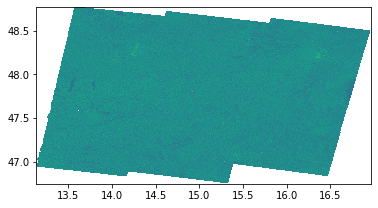

In [4]:
# Plot the raster
show(radar)

In [5]:
# Select a random polygon
n = 24654
polys = polygons[n:n+1]

In [6]:
# Show the fields info to get an idea
polys

,FS_KENNUNG,SNAR_BEZEI,SL_FLAECHE,ID,geometry
24654,67238782.0,MÄHWIESE/-WEIDE DREI UND MEHR NUTZUNGEN,3.310888,49854,"POLYGON ((493613.511 371126.320, 493613.002 37..."


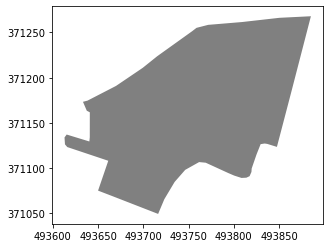

In [7]:
# Plot them
fig, ax = plt.subplots()
polys.plot(ax=ax, facecolor='gray');

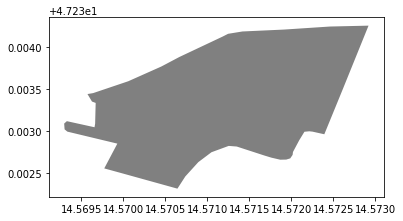

In [8]:
# We have to change the projection
polys = polys.to_crs(radar.crs)
fig, ax = plt.subplots()
polys.plot(ax=ax, facecolor='gray');
xmin, xmax, ymin, ymax = plt.axis()
bbox = box(xmin, ymin, xmax, ymax)

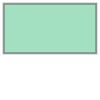

In [9]:
bbox

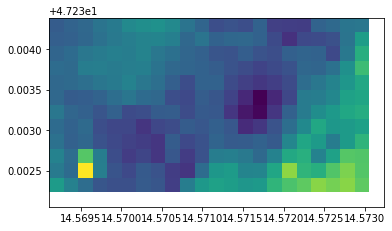

In [10]:
# Clip image around fields
# TODO clip around bbox and then choose fields
geo = gpd.GeoDataFrame({'geometry': bbox}, index=[0], crs=radar.crs)
def getFeatures(gdf):
    """Function to parse features from GeoDataFrame in such a manner that rasterio wants them"""
    import json
    return [json.loads(gdf.to_json())['features'][0]['geometry']]
coords = getFeatures(geo)
out_img, out_transform = mask(dataset=radar, shapes=coords, crop=True)
out_meta = radar.meta.copy()
epsg_code = int(radar.crs.data['init'][5:])
out_meta.update({"driver": "GTiff",
                           "height": out_img.shape[1],
                           "width": out_img.shape[2],
                           "transform": out_transform,
                           "crs": ss.parse.from_epsg_code(epsg_code).to_proj4()})
out_tif = '/home/mlamarre/Documents/FieldTimeSeries/clipped/test.tif'
with rasterio.open(out_tif, "w", **out_meta) as dest:
    dest.write(out_img)
clipped = rasterio.open(out_tif)
show((clipped))

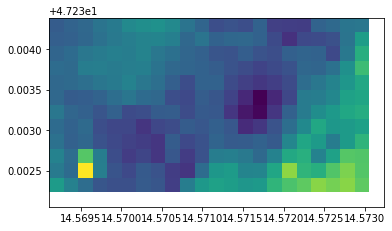

<Figure size 432x288 with 0 Axes>

In [17]:
# Show selected fields on raster (TODO)
ax2 = show(clipped)
polys.plot(ax=ax2, facecolor='None', edgecolor='red', linewidth=2)


In [26]:
# Do the zonal stats
array = clipped.read(1)
transform = clipped.transform

zs = zonal_stats(polys, array, affine=transform, stats=['min', 'max', 'mean', 'median', 'majority'])
print(zs)

[{'min': -28.323333740234375, 'max': -19.57878303527832, 'mean': -23.47757593277962, 'median': -23.48519802093506, 'majority': -28.323333740234375}]


In [171]:
# Define region of interest
west_bound = 15.0
east_bound = 15.01
north_bound = 48.01
south_bound = 48.0
AOI = box(minx=west_bound, miny=south_bound, maxx=east_bound, maxy=north_bound)
print(AOI.bounds)

(15.0, 48.0, 15.01, 48.01)


In [172]:
# Change the Coordinate Reference system to match that of the polygons
AOI_df = gpd.GeoDataFrame({'geometry':AOI}, index=[0], crs=radar.crs)
AOI_df = AOI_df.to_crs(polygons.crs)
print(AOI_df.bounds)

            minx           miny           maxx           maxy
0  524362.723476  456961.120163  525132.380883  458088.455043


In [173]:
# Transform back into a (box) polygon
AOI_ = box(minx=AOI_df.bounds.loc[0]['minx'],
           miny=AOI_df.bounds.loc[0]['miny'],
           maxx=AOI_df.bounds.loc[0]['maxx'],
           maxy=AOI_df.bounds.loc[0]['maxy'])
print(AOI_.bounds)

(524362.7234763639, 456961.1201626792, 525132.3808825933, 458088.4550425114)


In [174]:
# Iterate over all the polygons (long) and check if point(s)/centroid within AOI 
idxs = []
for index, row in polygons.iterrows():
    if index % 2500 == 0:
        print('Scanned {} out of {} fields. ({}%)'.format(index,polygons.shape[0],index/polygons.shape[0]*100),end='\r')
    if(Point(row.geometry.exterior.coords[0]).within(AOI_)):
        idxs.append(index)
print('{} fields were selected'.format(len(idxs)))

46 fields were selected2522622 fields. (99.99516376214906%))


In [198]:
# Keep the polygons of interest and change their CRS
polys_OI = polygons.iloc[idxs]
polys_OI = polys_OI.to_crs(radar.crs)

In [186]:
print(polygons.shape)
print(polys_OI.shape)
print(polys.shape)

(2522622, 5)
(46, 5)
(1, 5)


In [208]:
# Get the values of radar as numpy array and the transform of the raster
array = radar.read(1)
transform = radar.transform

In [214]:
# Iterate over the fields and get the zonal stats
ZONAL_STATS = []
for index, row in polys_OI.iterrows():
    #print(row)
    ZONAL_STATS.append(zonal_stats(row.geometry, array, affine=transform, stats=['mean']))
print(ZONAL_STATS)

[[{'mean': -15.153173327445984}], [{'mean': -20.337428622775608}], [{'mean': -19.57264057795207}], [{'mean': -20.98861312866211}], [{'mean': -19.105502462387086}], [{'mean': -19.834018230438232}], [{'mean': -18.589762872265233}], [{'mean': -20.167970145376106}], [{'mean': -20.8634672164917}], [{'mean': -15.825681686401367}], [{'mean': None}], [{'mean': -16.29479455947876}], [{'mean': -18.660181762306554}], [{'mean': None}], [{'mean': -22.623764991760254}], [{'mean': -20.567710609436034}], [{'mean': -20.94820213317871}], [{'mean': -18.963496272846804}], [{'mean': -18.790723939375443}], [{'mean': -15.801183700561523}], [{'mean': -19.616851854725045}], [{'mean': None}], [{'mean': -16.003766536712646}], [{'mean': -19.30393023326479}], [{'mean': -20.441454415369517}], [{'mean': None}], [{'mean': -17.581441116333007}], [{'mean': -19.624328129327118}], [{'mean': -18.68580912053585}], [{'mean': -21.26272225379944}], [{'mean': -17.274840094826438}], [{'mean': -18.790028897727407}], [{'mean': -1